[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/STMicroelectronics/stm32ai/blob/master/AI_resources/HAR/Human_Activity_Recognition.ipynb)

# Human Activity Recognition

This notebook shows the process of creating a basic motion sensing activity classifier model, using Keras, for STM32 embedded applications.


In [1]:
import tensorflow as tf
print(tf.version.VERSION)

2.14.0


# download model

In [2]:
!wget -nc https://github.com/STMicroelectronics/stm32ai/raw/master/AI_resources/HAR/model.h5

zsh:1: command not found: wget


In [3]:
import glob
import numpy as np

# Load data into memory
labels = ['stationary', 'walking', 'running']
x_recordings = []
y_recordings = []
recordings_filenames = []
for i, label in enumerate(labels):
    # filenames = glob.glob('ST_HAR_Dataset/dataset/' + label + '/*.csv') 
    #filenames = glob.glob('teams/lunar_bytes/v3_13March_2025/output_data/' + label + '/*.csv')
    filenames = glob.glob('teams/lunar_bytes/v3_13March_2025/output_data_modified_for_evaluation/' + label + '/*.csv')

    for filename in filenames:
        data = np.loadtxt(filename, delimiter=',')
        x_recordings.append(data)
        y_recordings.append(i)
        recordings_filenames.append(filename)

x_recordings = np.array(x_recordings).reshape(len(x_recordings), -1, 3)
y_recordings = np.array(y_recordings)

print(x_recordings.shape)
print(y_recordings.shape)

(60, 52, 3)
(60,)


# Exploring the dataset

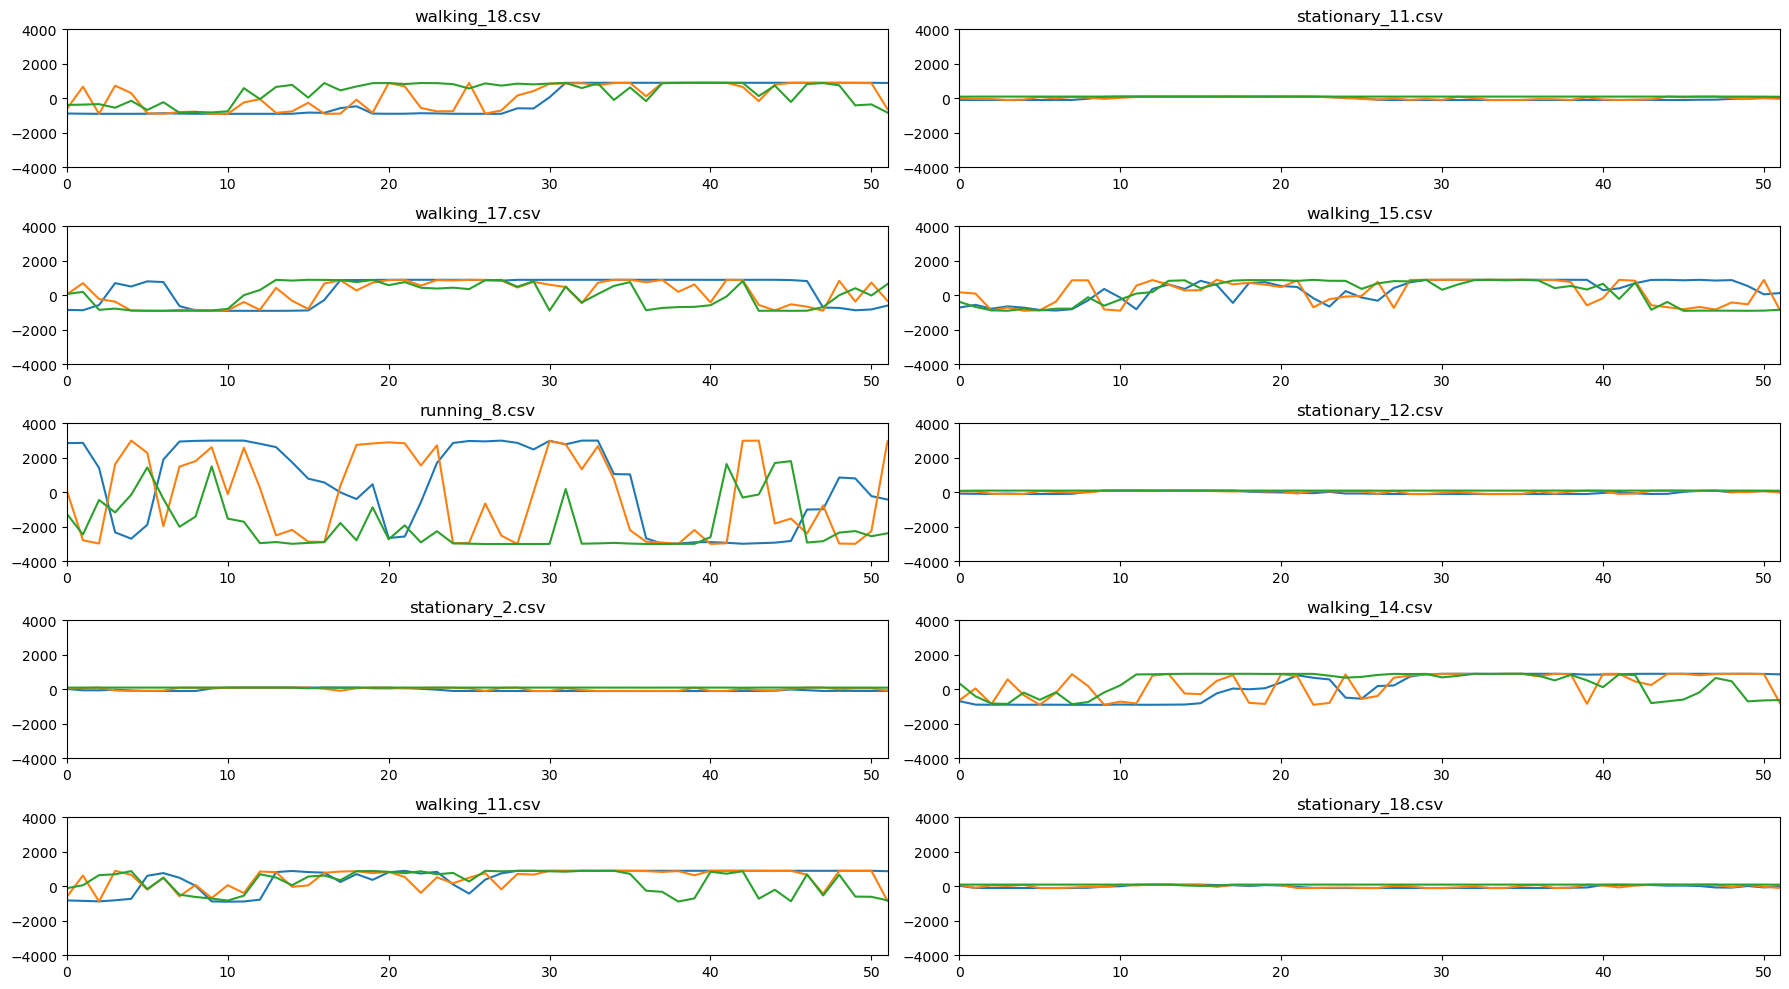

In [4]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Plot some captures
random.seed(10)
unique_rands = random.sample(range(len(x_recordings)), 10)
plt.figure(figsize=(18, 10))
for i, n in enumerate(unique_rands):
    plt.subplot(5, 2, i + 1)
    plt.margins(x=0, y=-0.25)
    plt.plot(x_recordings[n])
    plt.ylim(-4000, 4000)  # 4000 mg acc. range
    plt.title(recordings_filenames[n].split('/')[-1])
plt.tight_layout()
plt.show()

In [5]:
import numpy as np

def frame(x, frame_len, hop_len):
    '''Slice a 3D data array into (overlapping) frames.

    Example
    --------
    >>> x = np.array([[0, 1, 2],
                      [10, 11, 12],
                      [20, 21, 22],
                      [30, 31, 32],
                      [40, 41, 42],
                      [50, 51, 52],
                      [60, 61, 62]])
    >>> frames = x.frame(x, 3, 2)
    >>> x.shape
    (7, 3)
    >>> frames.shape
    (3, 3, 3)
    '''

    assert(x.shape == (len(x), 3))
    assert(x.shape[0] >= frame_len)
    assert(hop_len >= 1)

    n_frames = 1 + (x.shape[0] - frame_len) // hop_len
    shape = (n_frames, frame_len, x.shape[1])
    strides = ((hop_len * x.strides[0],) + x.strides)
    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

x_frames = []
y_frames = []
for i in range(x_recordings.shape[0]):
    # frames = frame(x_recordings[i], 26, 26) # no overlap
    frames = frame(x_recordings[i], 26, 13) # 50% overlap
    x_frames.append(frames)
    y_frames.append(np.full(frames.shape[0], y_recordings[i]))

print(np.array(x_frames).shape)
x_frames = np.concatenate(x_frames)
y_frames = np.concatenate(y_frames)
print(x_frames.shape)

# Each output label is an integer between 0 and 2:
print(y_frames.shape)
print(labels)

(60, 3, 26, 3)
(180, 26, 3)
(180,)
['stationary', 'walking', 'running']


In [6]:
print(y_frames.shape)
for i, y in enumerate(y_frames):
  print(i, y)

(180,)
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 1
75 1
76 1
77 1
78 1
79 1
80 1
81 1
82 1
83 1
84 1
85 1
86 1
87 1
88 1
89 1
90 1
91 1
92 1
93 1
94 1
95 1
96 1
97 1
98 1
99 1
100 1
101 1
102 1
103 1
104 1
105 1
106 1
107 1
108 1
109 1
110 1
111 1
112 1
113 1
114 1
115 1
116 1
117 1
118 1
119 1
120 2
121 2
122 2
123 2
124 2
125 2
126 2
127 2
128 2
129 2
130 2
131 2
132 2
133 2
134 2
135 2
136 2
137 2
138 2
139 2
140 2
141 2
142 2
143 2
144 2
145 2
146 2
147 2
148 2
149 2
150 2
151 2
152 2
153 2
154 2
155 2
156 2
157 2
158 2
159 2
160 2
161 2
162 2
163 2
164 2
165 2
166 2
167 2
168 2
169 2
170 2
171 2
172 2
173 2
174 2
175 2
176 2
177 2
178 2
179 2


In [7]:
# Normalize input data between [-1;1]
x_frames_normed = x_frames / 4000

# Load pre-trained model

In [8]:
model = tf.keras.models.load_model('model.h5')

6/6 [==============================] - 0s 661us/step


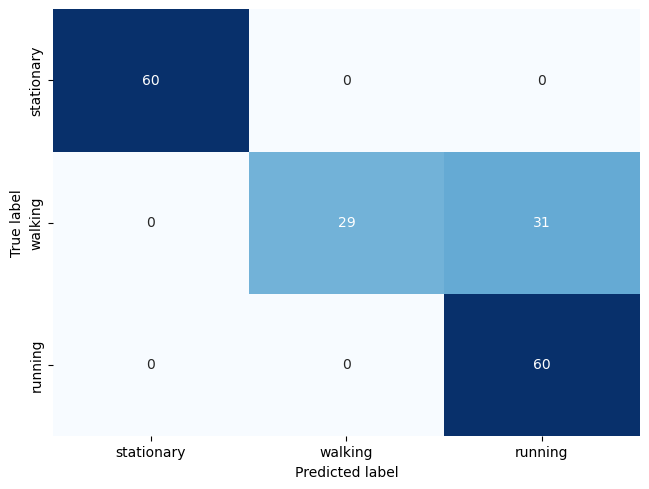

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Y_pred = model.predict(x_frames_normed)
y_pred = np.argmax(Y_pred, axis=1)
confusion_matrix = tf.math.confusion_matrix(y_frames, y_pred)

plt.figure()
sns.heatmap(confusion_matrix,
            annot=True,
            xticklabels=labels,
            yticklabels=labels,
            cmap=plt.cm.Blues,
            fmt='d', cbar=False)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [10]:
for i, y in enumerate(Y_pred):
  print(i, y)

0 [9.9823087e-01 1.7633706e-03 5.8022656e-06]
1 [9.981686e-01 1.825563e-03 5.871756e-06]
2 [9.9810815e-01 1.8848522e-03 6.9707185e-06]
3 [9.9820161e-01 1.7922584e-03 6.0199541e-06]
4 [9.9815804e-01 1.8357543e-03 6.2410340e-06]
5 [9.9811041e-01 1.8822905e-03 7.2238076e-06]
6 [9.9822110e-01 1.7730579e-03 5.8293581e-06]
7 [9.9818856e-01 1.8057242e-03 5.6790591e-06]
8 [9.9815887e-01 1.8346865e-03 6.4027959e-06]
9 [9.9819571e-01 1.7981689e-03 6.1861301e-06]
10 [9.9809664e-01 1.8963326e-03 7.0234137e-06]
11 [9.9814820e-01 1.8454194e-03 6.4599453e-06]
12 [9.9815482e-01 1.8389707e-03 6.2382710e-06]
13 [9.980883e-01 1.904754e-03 6.848050e-06]
14 [9.9816531e-01 1.8283108e-03 6.3914226e-06]
15 [9.9812287e-01 1.8692712e-03 7.8254652e-06]
16 [9.9818987e-01 1.8038298e-03 6.2475451e-06]
17 [9.9814737e-01 1.8462363e-03 6.4276160e-06]
18 [9.9816483e-01 1.8283152e-03 6.9208104e-06]
19 [9.9812776e-01 1.8651936e-03 7.0690658e-06]
20 [9.9816835e-01 1.8254616e-03 6.2458676e-06]
21 [9.9817050e-01 1.8229021e-